# Regional means

This notebook should demonstrate how CORDEX datasets can be used for looking at regional and local scales. This often involves masking and averaging over a limited area of the dataset, e.g., a country or city.

In [1]:
import os

import cf_xarray as cfxr
import numpy as np
import xarray as xr

We are interested in looking at the change in the temperature with respect to the reference period from 1981 to 2010.

Define a plotting function

In [2]:
import cartopy.crs as ccrs

def plot(
    da,
    transform=ccrs.PlateCarree(),
    projection=ccrs.PlateCarree(),
    vmin=None,
    vmax=None,
    cmap=None,
    borders=True,
    xlocs=range(-180, 180, 2),
    ylocs=range(-90, 90, 2),
    extent=None,
    figsize=(15, 10),
    title=None,
):
    """plot a domain using the right projections and transformations with cartopy"""
    import cartopy.feature as cf
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    if extent:
        # ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
        ax.set_extent(extent, crs=projection)
    ax.gridlines(
        draw_labels=True, linewidth=0.5, color="gray", xlocs=xlocs, ylocs=ylocs
    )
    da.plot(ax=ax, cmap=cmap, transform=transform, vmin=vmin, vmax=vmax)
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    if borders:
        ax.add_feature(cf.BORDERS)
    if title is not None:
        ax.set_title(title)

## Masking with `regionmask`

In [3]:
import regionmask
import cordex as cx
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

In [4]:
prudence = regionmask.defined_regions.prudence
prudence

<regionmask.Regions 'PRUDENCE'>
Source:   Christensen and Christensen, 2007, Climatic Change 81:7-30 (https:/...
overlap:  True

Regions:
1 BI     British Isles
2 IP Iberian Peninsula
3 FR            France
4 ME        Mid-Europe
5 SC       Scandinavia
6 AL              Alps
7 MD     Mediterranean
8 EA    Eastern Europe

[8 regions]

Let's have a look at those regions:

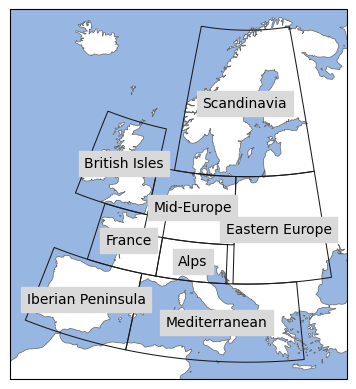

In [5]:
ds = cx.cordex_domain("EUR-11", dummy="topo")

#plt.rcParams["figure.figsize"] = (10, 8)
pole = (
    ds.cf["grid_mapping"].grid_north_pole_longitude,
    ds.cf["grid_mapping"].grid_north_pole_latitude,
)
proj = ccrs.RotatedPole(*pole)
ax = prudence.plot(
    add_ocean=True,
    projection=proj,
    resolution="50m",
    label="name",
    line_kws=dict(lw=0.75),
)

Create a mask for each region that fits our dataset coordinates.

In [6]:
mask_prudence = prudence.mask_3D(ds.lon, ds.lat)

We can now use the mask to only look at a certain region, e.g.

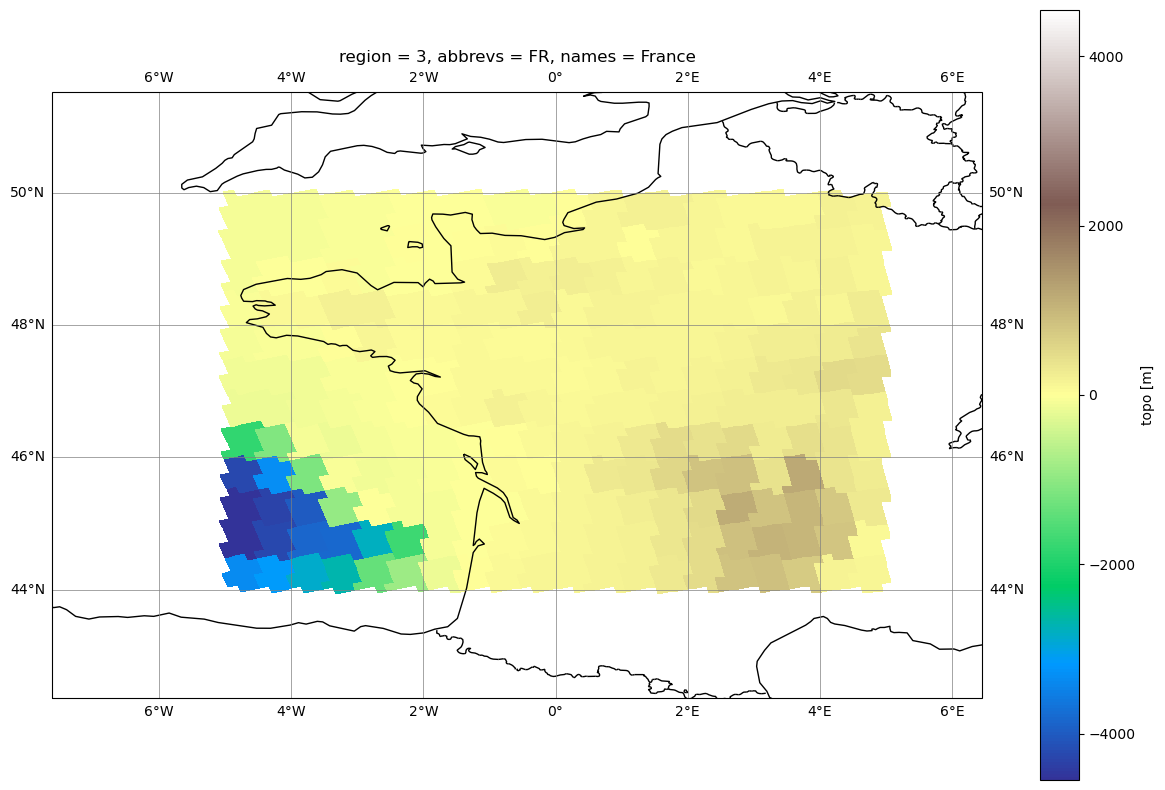

In [7]:
me_topo = ds.topo.where(
    mask_prudence.isel(region=(mask_prudence.names == "France")).squeeze(),
    drop=True,
)
plot(
    me_topo,
    transform=ccrs.RotatedPole(*pole),
    projection=ccrs.PlateCarree(),
    cmap="terrain",
    figsize=(15,10)
)

Let's compute a spatial average over each region to compare the changes between them

The computation so far was done [lazily](https://docs.xarray.dev/en/stable/user-guide/dask.html). Before plotting, we will explictly trigger the compuation here.

Let's look at the change in yearly means for each region! We will use a rolling mean over the climatic timescale of 30 years.

In [8]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/larsbuntemeyer/proxy/8787/status,
Dashboard: /user/larsbuntemeyer/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34939,Workers: 4
Dashboard: /user/larsbuntemeyer/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.88 GiB
Comm: tcp://127.0.0.1:40471,Total threads: 4
Dashboard: /user/larsbuntemeyer/proxy/39761/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:39133,


In [9]:
from collections import defaultdict, OrderedDict
import tqdm
import fsspec
import intake
import dask
import xarray as xr
import cf_xarray as cfxr

xr.set_options(keep_attrs=True)

In [10]:
url = "https://euro-cordex.s3.eu-central-1.amazonaws.com/catalog/CORDEX-CMIP5.json"
cat = intake.open_esm_datastore(url)
subset = cat.search(
    variable_id="tas", experiment_id=["historical", "rcp26", "rcp45", "rcp85"]
)

In [11]:
dsets = subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    storage_options={"anon": True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.CORDEX_domain.institute_id.driving_model_id.experiment_id.member.model_id.rcm_version_id.frequency'


In [12]:
def sort_datasets(dsets):
    results = defaultdict(dict)
    for dset_id, ds in tqdm.tqdm(dsets.items()):
        exp_id = dset_id.split(".")[4]
        new_id = dset_id.replace(f"{exp_id}.", "")
        if exp_id != "historical":
            ds = ds.sel(time=slice("2006", "2100"))
        else:
            ds = ds.sel(time=slice("1950", "2005"))
        results[exp_id][new_id] = ds
    return OrderedDict(sorted(results.items()))


dsets_sorted = sort_datasets(dsets)

100%|██████████| 165/165 [00:00<00:00, 420.86it/s]


In [15]:
def weighted_mean(ds):
    mask = prudence.mask_3D(ds.cf['longitude'], ds.cf['latitude'])
    #mask = mask_prudence#.assign_coords(region=mask_prudence.names)
    return ds.cf.weighted(mask).mean(dim=("X", "Y"))  


def yearly_regional_mean(ds):
    """compute yearly mean for one dataset"""
    return weighted_mean(ds.groupby("time.year").mean())


def ensemble_mean(dsets):
    """compute ensemble yearly mean"""
    return xr.concat(
        [yearly_regional_mean(ds.cf["tas"]) for ds in dsets.values()],
        dim=xr.DataArray(list(dsets.keys()), dims="dset_id"),
        coords="minimal",
        compat="override",
    )

In [16]:
%time ensembles = {exp_id: ensemble_mean(dsets).compute() for exp_id, dsets in dsets_sorted.items()}

CPU times: user 3min 17s, sys: 16.6 s, total: 3min 34s
Wall time: 15min 9s


In [18]:
ensembles.keys()

dict_keys(['historical', 'rcp26', 'rcp45', 'rcp85'])

In [20]:
ensemble = xr.concat(
    list(ensembles.values()),
    dim=xr.DataArray(list(ensembles.keys()), dims="experiment_id"),
    coords="minimal",
    compat="override",
)

In [21]:
dset_id = ensemble.where(ensemble < 100.0, drop=True).dset_id
ensemble.loc[dict(dset_id=dset_id)] = ensemble.sel(dset_id=dset_id) + 273.5

In [23]:
ensemble.to_netcdf("prudence-tas-ensemble.nc")

In [24]:
ensemble

<xarray.DataArray 'tas' (experiment_id: 4, dset_id: 63, year: 151, region: 8)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [282.0676773 , 286.4706811 , 283.86624815, ..., 280.39552603,
          288.09469764, 280.96285541],
         [281.58259658, 286.25678469, 283.98711226, ..., 280.87594902,
          288.60818494, 281.86947973],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[282.12065155, 286.45453691, 284.38364106, ..., 281.16724512,
          288.39245416, 282.22631579],
         [281.73169325, 285.97190272, 283.90400665, ..., 280.41800434,
          287.77664404, 281.29969752],
         [281.63742072, 286.16153586, 283.52040251, ..., 280.12982646,
          287.79328279, 280.60958863],
...
         [286.14950509, 290.91811382, 288.58112999, ..., 284.33248373,
          291.92623854, 285.63030853],
         [285.28649337, 291.09694031, 288.43460118, ..., 285.10349783,
          292.37665286, 285.74016939],
         [285.56762925, 291.20474365, 288.8       , ..., 285.67128525,
          292.73073872, 286.7661827 ]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [284.38244763, 290.56771538, 286.35424668, ..., 284.57928416,
          292.12599171, 284.89637024],
         [284.25290698, 290.10684484, 286.44420236, ..., 284.88522234,
          292.4460067 , 285.00372051],
         [284.48375937, 290.85455195, 286.54726736, ..., 284.7132321 ,
          292.02362482, 284.41436782]]]])
Coordinates:
  * year                        (year) int64 1950 1951 1952 ... 2098 2099 2100
  * region                      (region) int64 1 2 3 4 5 6 7 8
  * dset_id                     (dset_id) <U78 'cordex.EUR-11.CLMcom-ETH.CNRM...
    crs                         |S1 b''
    Lambert_Conformal           |S1 b''
    rotated_latitude_longitude  int32 -2147483647
    height                      float64 2.0
    rotated_pole                |S1 b''
    abbrevs                     (region) <U2 'BI' 'IP' 'FR' ... 'AL' 'MD' 'EA'
    names                       (region) <U17 'British Isles' ... 'Eastern Eu...
  * experiment_id               (experiment_id) <U10 'historical' ... 'rcp85'
Attributes:
    cell_methods:   time: mean
    grid_mapping:   rotated_pole
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

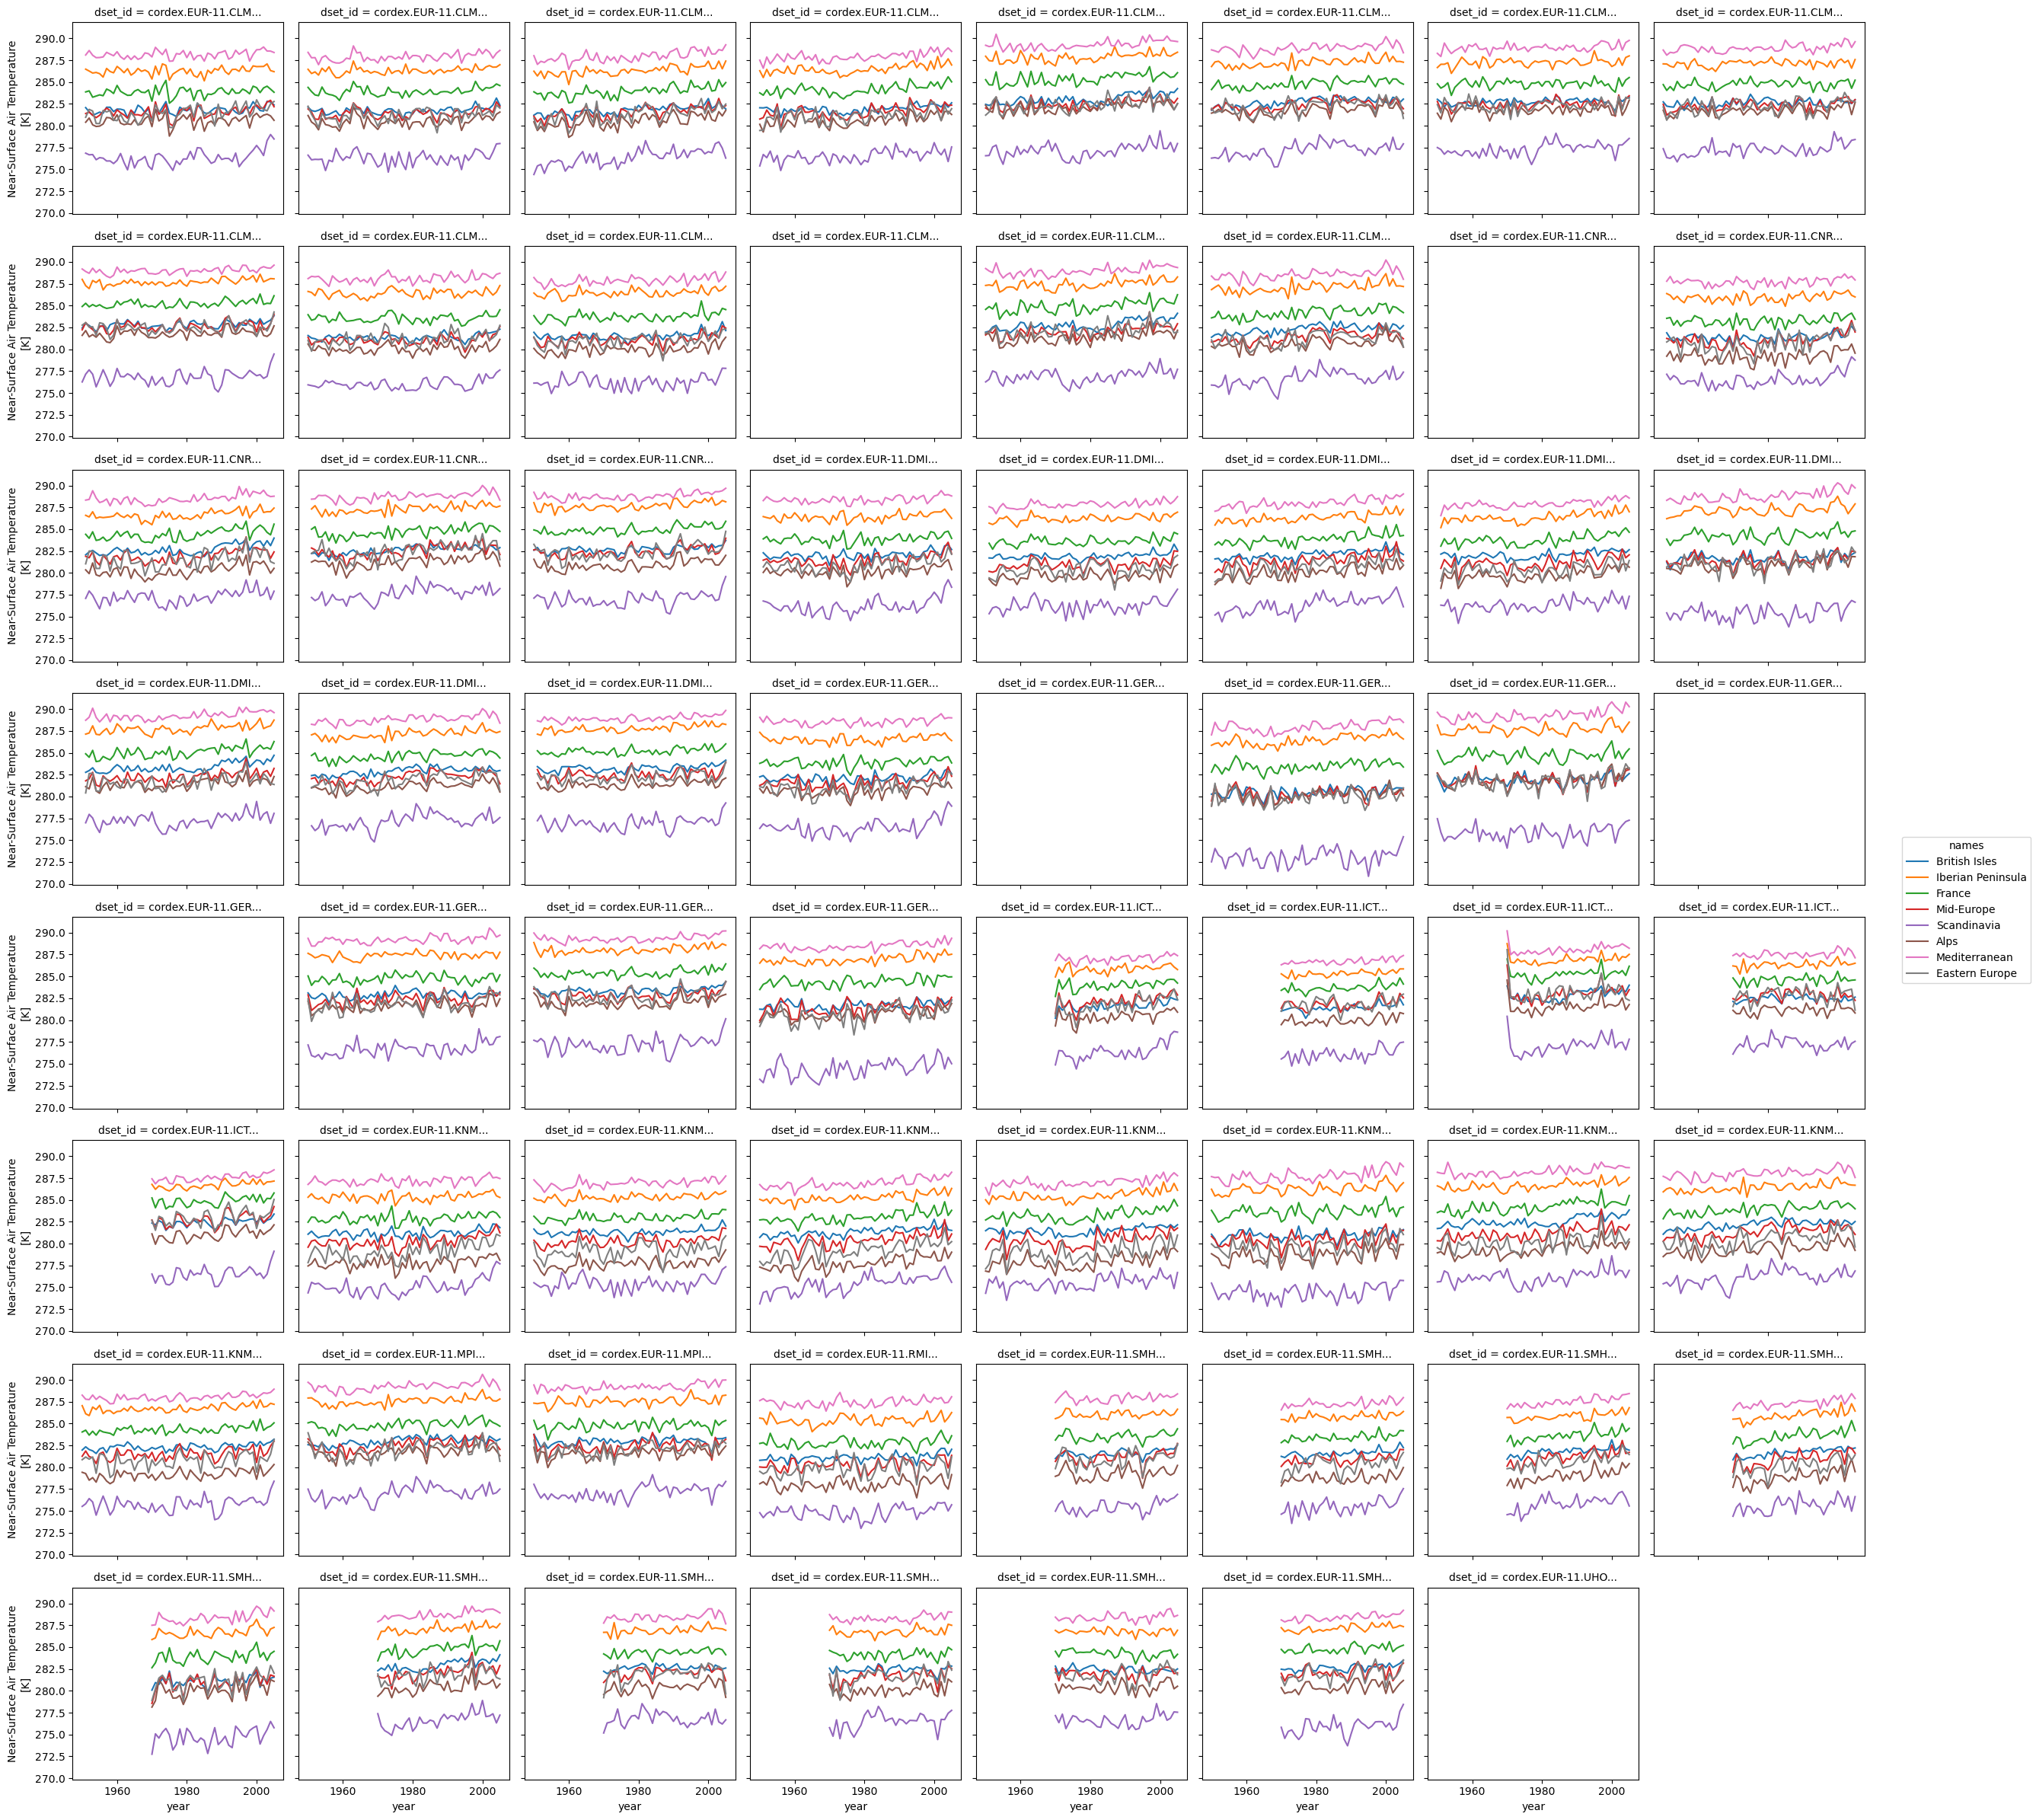

In [26]:
ensemble.swap_dims(region="names").sel(experiment_id="historical").plot(hue="names", col="dset_id", col_wrap=8)

In [43]:
change = ensemble - ensemble.sel(experiment_id = "historical", year=slice(1961,1990)).mean('year')

In [46]:
df = change.to_dataframe().reset_index()[["year", "experiment_id", "dset_id", "names", "tas"]]
df

,year,experiment_id,dset_id,names,tas
0,1950,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,British Isles,NaN
1,1950,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,Iberian Peninsula,NaN
2,1950,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,France,NaN
3,1950,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,Mid-Europe,NaN
4,1950,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,Scandinavia,NaN
...,...,...,...,...,...
304411,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Mid-Europe,NaN
304412,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Scandinavia,NaN
304413,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Alps,NaN
304414,2100,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,Mediterranean,NaN


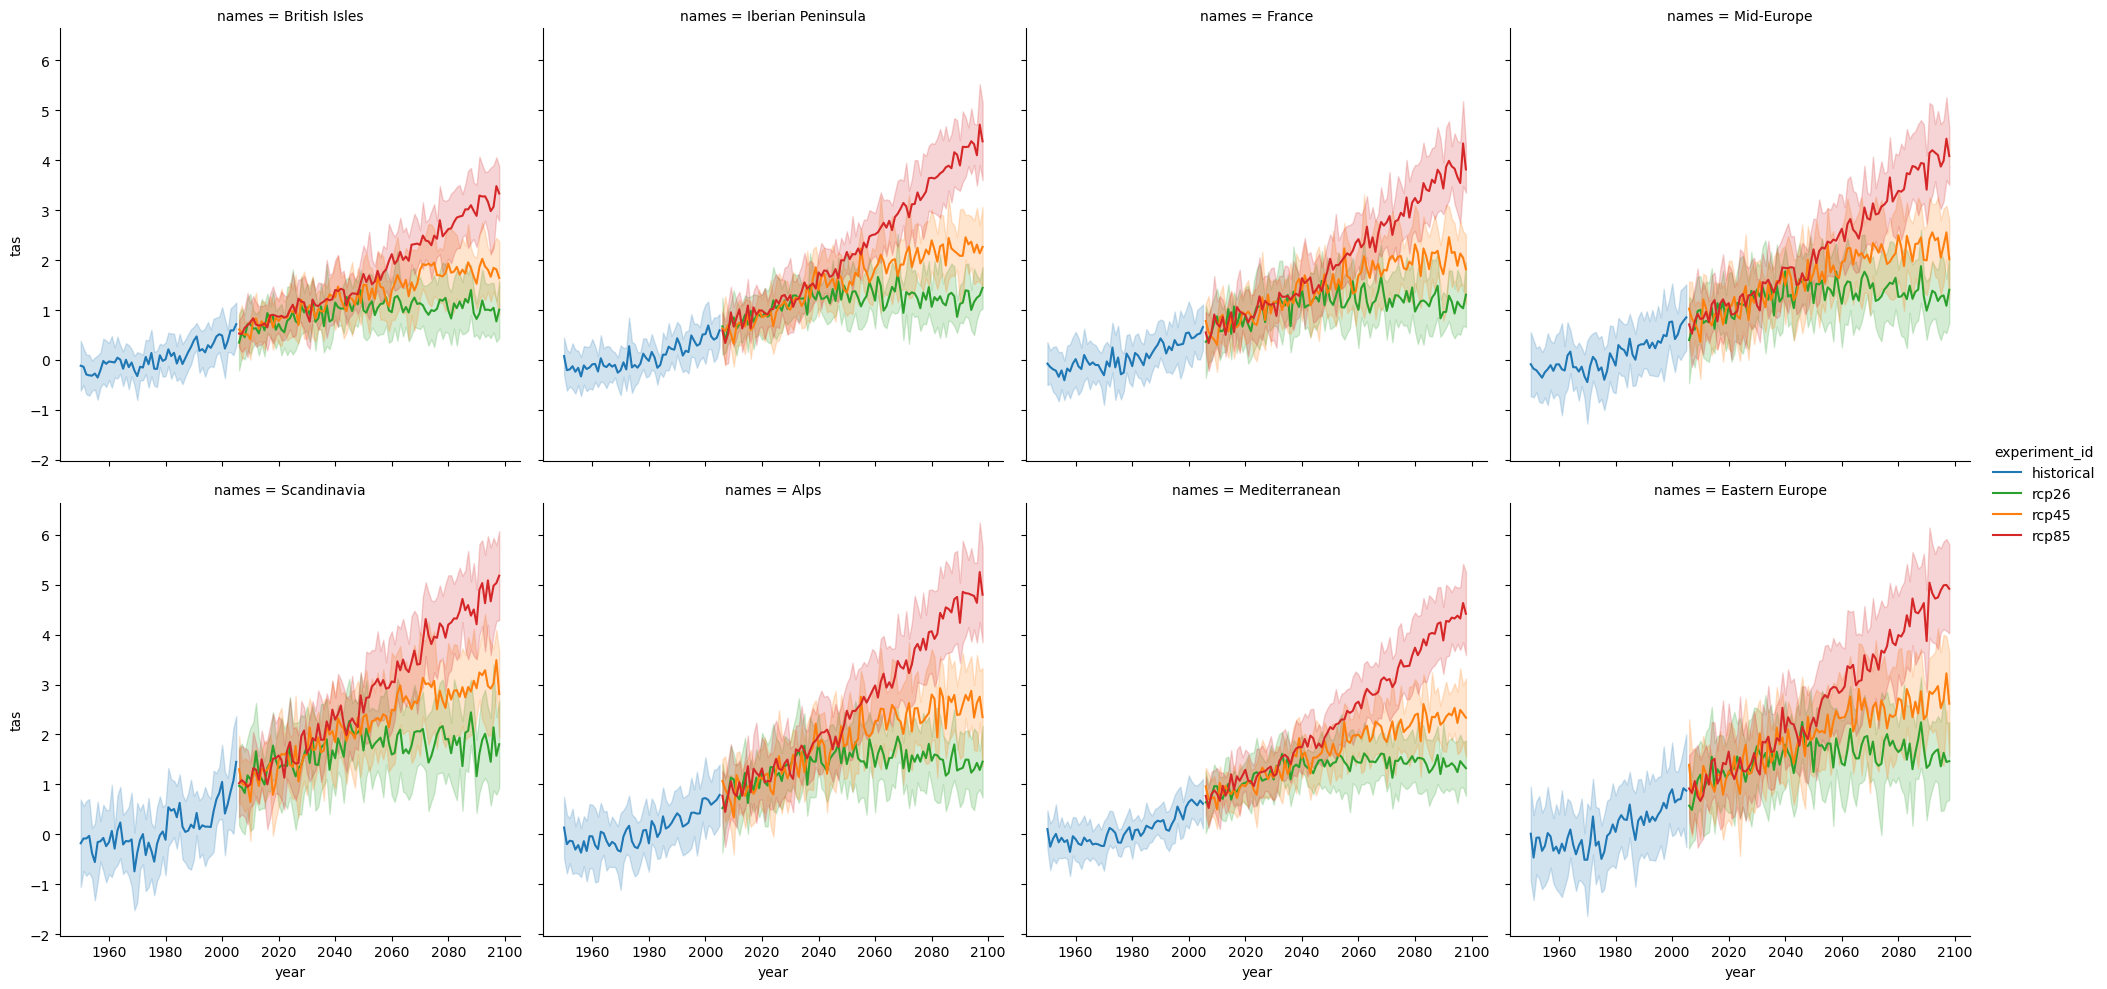

In [50]:
import seaborn as sns

palette = {"historical": "C0", "rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(
    data=df[(df["year"] >= 1950) & (df["year"] <= 2098)],
    x="year",
    y="tas",
    hue="experiment_id",
    kind="line",
    #errorbar=("ci", 95),
    errorbar="sd",
    #aspect=2,
    palette=palette,
    col="names",
    col_wrap=4
)
#g.set(title="Yearly model mean with 95th percentile confidence interval")